<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Transformadors_Capacitats_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capacitats dels tokenizer ràpids**

---

Els tokenitzadors, especialment els recolzats per la biblioteca Tokenizers, poden fer molt més.
Els tokenizers lents són els escrits en Python dins de la biblioteca **Transformers**, mentre que les versions ràpides són les que ofereix **Tokenizers**, que estan escrites en Rust.

A més de les seves capacitats de paral·lelització, la funcionalitat clau dels tokenitzadors ràpids és que sempre fan un seguiment de l'abast original de textos d'on provenen els testimonis finals, una característica que anomenem mapatge compensat . Això, al seu torn, desbloqueja funcions com l'assignació de cada paraula a les fitxes que ha generat o la correspondència de cada caràcter del text original al testimoni que hi ha dins, i viceversa.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

In [ ]:
tokenizer.is_fast

In [ ]:
encoding.is_fast

In [ ]:
#encoding.tokens()
print(" ".join(encoding.tokens()))


In [ ]:
encoding.word_ids()

Es pot observar que les fitxes especials del tokenizer [CLS]i [SEP]estan assignades a None, i després cada testimoni s'assigna a la paraula de la qual prové. Això és especialment útil per determinar si un testimoni està a l'inici d'una paraula o si dos testimonis estan a la mateixa paraula. Podríem confiar en el ##prefix per a això, però només funciona per a tokenitzadors semblants a BERT; aquest mètode funciona per a qualsevol tipus de tokenitzador sempre que sigui ràpid. En el següent capítol, veurem com podem utilitzar aquesta capacitat per aplicar correctament les etiquetes que tenim per a cada paraula als testimonis en tasques com el reconeixement d'entitats amb nom (NER) i l'etiquetatge de part de la veu (POS). També el podem utilitzar per emmascarar totes les fitxes procedents de la mateixa paraula en el modelatge de llenguatge emmascarat (una tècnica anomenada emmascarament de paraules completes ).

In [ ]:
start, end = encoding.word_to_chars(3)
example[start:end]

Finalment, podem assignar qualsevol paraula o testimoni als caràcters del text original, i viceversa, mitjançant els mètodes word_to_chars()o token_to_chars()i char_to_word()o . char_to_token()Per exemple, el word_ids()mètode ens va dir que ##ylforma part de la paraula de l'índex 3, però quina paraula és a la frase? Ho podem esbrinar així:

# **Pipeline de classificació**

---
En un pipeline genèric:
Les tres fases són:

1. **Tokenització**: Es divideix el text en tokens (paraules o subparts).

1. **Inferència del model**: Els tokens es passen pel model per obtenir les prediccions.

1. **Postprocessament**: Es transforma la sortida del model en una forma fàcil d’entendre per a l’usuari (per exemple, etiquetes o puntuacions).

**Per què el postprocessament és especial al token-classification (NER)?**

---


Perquè el model fa una predicció per a cada token, i els tokens poden ser:

Fragments d’una paraula (com amb WordPiece o BPE).

Incloure prefixos com ## que indiquen que són una continuació de paraula.

Això crea dues dificultats:

1. **Agrupar tokens** en paraules senceres:
Per exemple, “Barcelona” podria ser dividida en dos tokens: Bar i ##celona. El model prediu una etiqueta per a cada part, però tu vols una única entitat "Barcelona".

2. **Filtrar etiquetes especials** (com B-LOC, I-LOC):
Les etiquetes segueixen un esquema com:

  * **B-PER** = Begin of a person

  * **I-PER** = Inside a person Això cal interpretar-ho per agrupar tokens adjacents en una única entitat reconeguda.


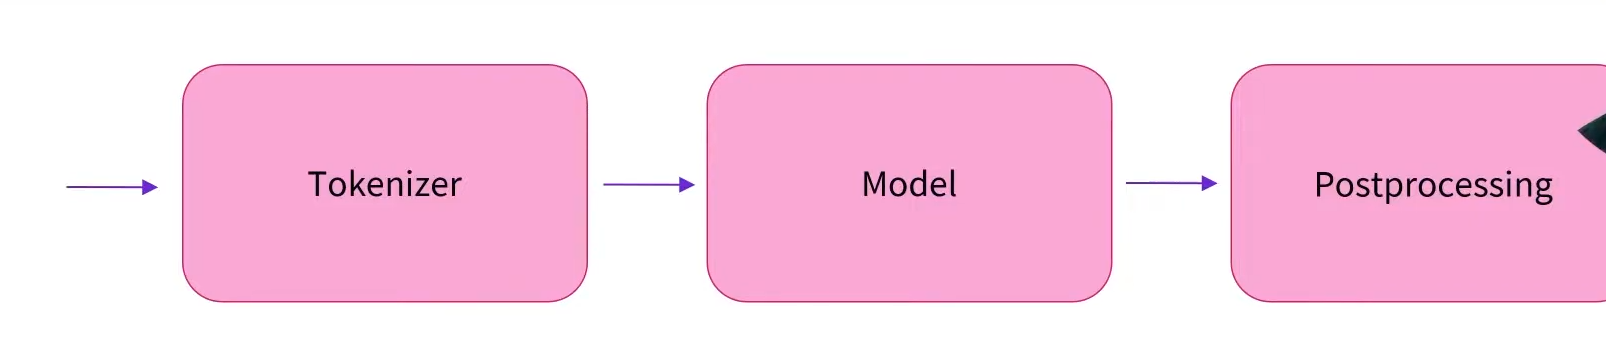

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

# No s’agrupen tokens.

# Obteció d'una predicció per a cada token individualment, encara que pertanyi a la mateixa entitat.

# Visualitza les etiquetes del tipus B-ORG, I-ORG, etc., aplicades a cada token.



In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

# Els tokens amb la mateixa entitat consecutius s’agrupen en una única entitat.

# És més útil i llegible per a aplicacions reals.

# La sortida és més neta i directa, sense preocupar-se per tokens fragmentats ni etiquetes BIO.

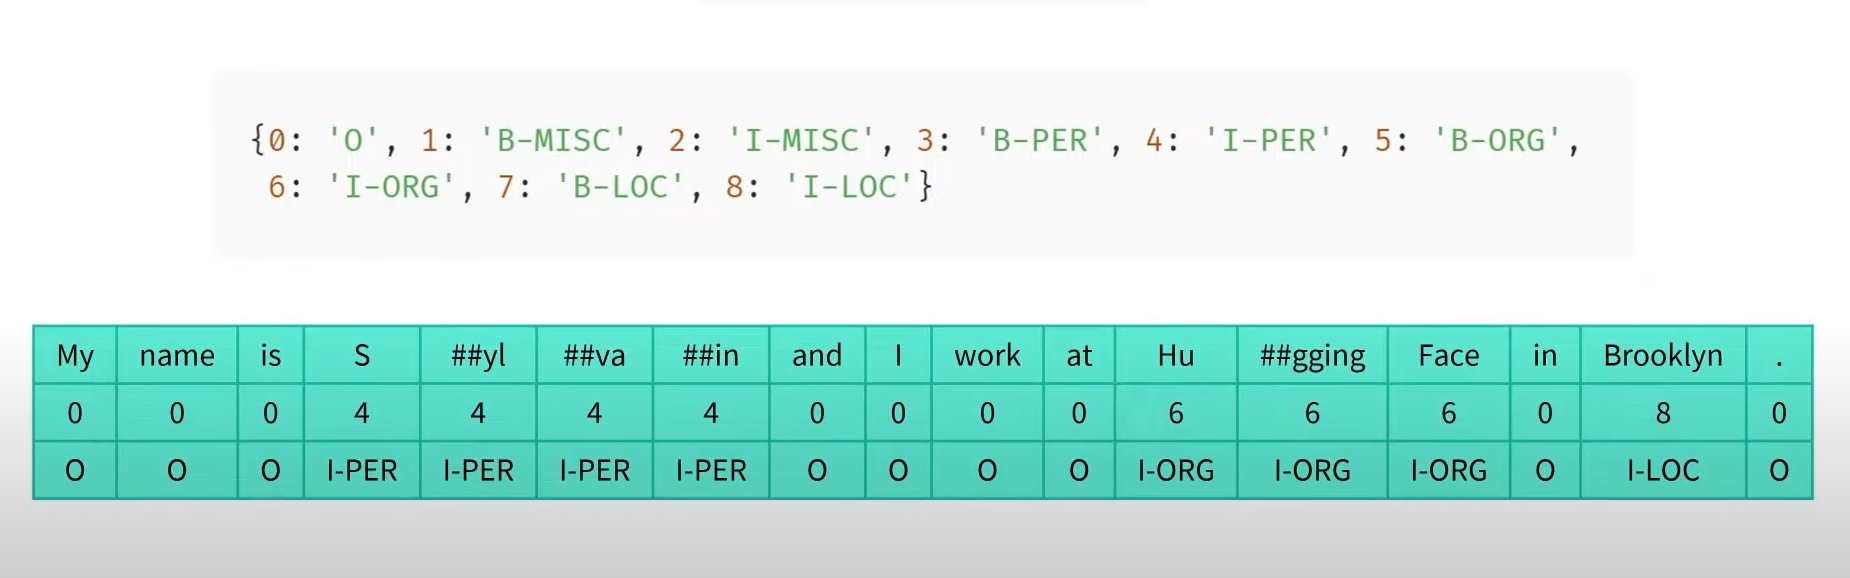

**De les entrades a les prediccions**

---

Primer cal tokenitzar l'entrada i passar-la pel model.

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="tf")
outputs = model(**inputs)

In [ ]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

# Sortida:
# (1, 19)	1 seqüència (batch size = 1), amb 19 tokens
# (1, 19, 9)	Per a cada token (19), el model ha predit 9 etiquetes possibles (tag classes com B-PER, I-ORG, etc.)

Procés:

1. **Convertir** logits a prediccions
1. **Argmax** per obtenir l'etiqueta predita

  * **Logits** → són valors bruts (no probabilitats)

  * **Softmax** → converteix logits en probabilitats

  * **Argmax** → selecciona la classe amb més probabilitat

    * argmax(softmax(logits)) == argmax(logits)

In [ ]:
import tensorflow as tf

probabilities = tf.math.softmax(outputs.logits, axis=-1)[0]
probabilities = probabilities.numpy().tolist()
predictions = tf.math.argmax(outputs.logits, axis=-1)[0]
predictions = predictions.numpy().tolist()
print(predictions)

In [ ]:
model.config.id2label

Amb aquest mapa, estem preparats per reproduir (gairebé completament) els resultats del primer pipeline; només podem agafar la puntuació i l'etiqueta de cada testimoni que no s'ha classificat com a O

In [ ]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

Per obtenir els desplaçaments, només hem de configurar return_offsets_mapping=Truequan apliquem el tokenitzador a les nostres entrades

In [ ]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

In [ ]:
example[12:14]

In [ ]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

In [ ]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # Remove the B- or I-
        label = label[2:]
        start, _ = offsets[idx]

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)